In [78]:
import math
!pip install ucimlrepo
!pip install matplotlib seaborn
# !pip install sklearn Already preinstalled
!pip install alibi
!pip install shap



[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


# Cervical cancer risk factor prediction
We consider the cervical cancer dataset contains indicators and risk factors for predicting whether a woman will get cervical cancer. The features include demographic data (such as age), lifestyle, and medical history. The objectives are: 1) to train a risk predictor (i.e., binary classifier) of cervical cancer, given the input features. 2) to identify the most important risk factors.

The features are:
1.	Age in years
2.	Number of sexual partners
3.	First sexual intercourse (age in years)
4.	Number of pregnancies
5.	Smoking (in years)
6.	Hormonal contraceptives (in years)
7.	Number of years with an intrauterine device (IUD)
8.	Has patient ever had a sexually transmitted disease (STD) yes or no
9.	Number of STD diagnoses
10.	Time since first STD diagnosis
11.	Time since last STD diagnosis
12.	hPV diagnostic

The target is the biopsy results: “Healthy” or “Cancer”.


## Download dataset, partition into train/test

In [4]:
from ucimlrepo import fetch_ucirepo

cervical_cancer = fetch_ucirepo(name='Cervical Cancer')

X = cervical_cancer.data.features
y = X['Biopsy']  # Ground truth diagnosis: Biopsy result

# access metadata
print('Number of instances', cervical_cancer.metadata.num_instances)
print('Summary', cervical_cancer.metadata.additional_info.summary)

# access variable info in tabular format
print('All variables', cervical_cancer.variables)

# Retain only a fraction of the features:

included_features = ['Age',
                     'Number of sexual partners',
                     'First sexual intercourse',
                     'Num of pregnancies',
                     'Smokes (years)',
                     'Hormonal Contraceptives (years)',
                     'IUD (years)',
                     'STDs',
                     'STDs: Number of diagnosis',
                     'STDs: Time since first diagnosis',
                     'STDs: Time since last diagnosis',
                     'Dx:HPV']

X = X[included_features]

Number of instances 858
Summary The dataset was collected at 'Hospital Universitario de Caracas' in Caracas, Venezuela. The dataset comprises demographic information, habits, and historic medical records of 858 patients. Several patients decided not to answer some of the questions because of privacy concerns (missing values).
All variables                                   name     role        type demographic  \
0                                  Age  Feature     Integer         Age   
1            Number of sexual partners  Feature  Continuous       Other   
2             First sexual intercourse  Feature  Continuous        None   
3                   Num of pregnancies  Feature  Continuous        None   
4                               Smokes  Feature  Continuous        None   
5                       Smokes (years)  Feature  Continuous        None   
6                  Smokes (packs/year)  Feature  Continuous        None   
7              Hormonal Contraceptives  Feature  Continuou

## Data cleaning.
Here, we display summary statistics and identify potential issues. Here, we find no aberrant values, but some features are missing for some instances; we replace missing feature values by the median of the dataset.

In [5]:
import pandas as pd
from sklearn.impute import SimpleImputer

print('Before imputation')
print(X.describe())

imputer = SimpleImputer(strategy="median")
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
print('after imputation')
print(X.describe())

Before imputation
              Age  Number of sexual partners  First sexual intercourse  \
count  858.000000                 832.000000                851.000000   
mean    26.820513                   2.527644                 16.995300   
std      8.497948                   1.667760                  2.803355   
min     13.000000                   1.000000                 10.000000   
25%     20.000000                   2.000000                 15.000000   
50%     25.000000                   2.000000                 17.000000   
75%     32.000000                   3.000000                 18.000000   
max     84.000000                  28.000000                 32.000000   

       Num of pregnancies  Smokes (years)  Hormonal Contraceptives (years)  \
count          802.000000      845.000000                       750.000000   
mean             2.275561        1.219721                         2.256419   
std              1.447414        4.089017                         3.764254   
min

## Data Partition

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

y_train = y_train.astype(int)
y_test = y_test.astype(int)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(643, 12) (215, 12) (643,) (215,)


---

## B. Logistic Regression

In [5]:
from sklearn import set_config

set_config(display='diagram')


### 1.	Train an L2-regularized logistic regression model on the training data set with an optimal using the AUCROC metric. You can use the sklearn.linear_model.LogisticRegressionCV function to automatically adjust the value of the L2 penalty.

In [6]:
from sklearn.linear_model import LogisticRegressionCV

logistic_model = LogisticRegressionCV(scoring='roc_auc', max_iter=1000)
logistic_model.fit(X_train, y_train)

LogisticRegressionCV(max_iter=1000, scoring='roc_auc')

### 2.	Report the classification performance on the train and test set (accuracy, AUCROC, and negative log-likelihood).

In [7]:
import numpy as np
from sklearn.metrics import accuracy_score, log_loss, classification_report, roc_auc_score


def report_performance(
        model,
        X_train=X_train, X_test=X_test,
        y_train=y_train, y_test=y_test,
        with_classification_report=False
):
    for name, X, y in zip(
            ['Train', 'Test'],
            [X_train, X_test],
            [y_train, y_test],
    ):
        print(name)
        y_pred = model.predict(X)

        if with_classification_report:
            # show y value counts
            print('Value counts:')
            print(y.value_counts())
            print(pd.Series(y_pred).value_counts())

            print('Classification report:')
            print(classification_report(y, y_pred, zero_division=np.nan))
        else:
            print('Accuracy:', accuracy_score(y, y_pred))

        print('AUCROC:', roc_auc_score(y, model.predict_proba(X)[:, 1]))
        print(
            'AUCROC2:',
            roc_auc_score(y, y_pred)
        )  # TODO: Pretty sure this is not the correct way to calculate AUCROC
        print('Negative log-likelihood:', log_loss(y, model.predict_proba(X)))

In [8]:
report_performance(logistic_model)

Train
Accuracy: 0.9362363919129082
AUCROC: 0.564925856899765
AUCROC2: 0.5
Negative log-likelihood: 0.2361046813052166
Test
Accuracy: 0.9348837209302325
AUCROC: 0.6002132196162047
AUCROC2: 0.5
Negative log-likelihood: 0.23982118480678138


### 3.	Calculate the feature importance (defined as the standard deviation of the feature effects) and visualize them as a bar plot.
### 4.	What are the most and least important features?

In [62]:
def calculate_feature_effects(model, X_train=X_train):
    if isinstance(model, Pipeline):
        preprocessor = model[:-1]
        model = model[-1]
        transformed_features = preprocessor.transform(X_train)
        transformed_feature_names = preprocessor.get_feature_names_out()
    else:
        transformed_features = X_train.to_numpy()
        transformed_feature_names = X_train.columns

    transformed_features_effects = transformed_features * model.coef_

    feature_effects = np.array([
        transformed_features_effects[:,
        [
            i
            for i, transformed_feature_name
            in enumerate(transformed_feature_names)
            if (
                f"_{feature_name}_" in transformed_feature_name
                or feature_name == transformed_feature_name
        )
        ]
        ].sum(-1)
        for feature_name in X_train.columns
    ]).T

    return pd.DataFrame(feature_effects, columns=X_train.columns)

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_feature_importance(feature_effects):
    feature_importance = feature_effects.std()
    feature_importance = pd.Series(feature_importance, index=X_train.columns).sort_values()

    print(f'Most important: {feature_importance.idxmax()} ({feature_importance.max():.4f})')
    print(f'Least important: {feature_importance.idxmin()} ({feature_importance.min():.4f})')
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=feature_importance, y=feature_importance.index)
    # show values
    for i, v in enumerate(feature_importance):
        plt.text(v, i, f'{v:.4f}', color='black', va='center')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

Most important: Age (0.0533)
Least important: Dx:HPV (0.0001)


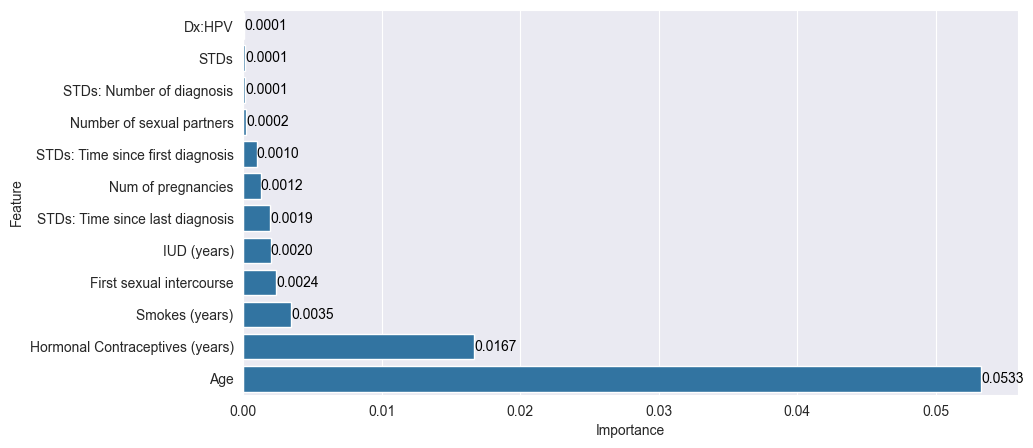

In [85]:
plot_feature_importance(calculate_feature_effects(logistic_model))

---

## C. Generalized Additive Model
The log-odds ratio of having cervical cancer is not expected to be linearly related to the numerical features. Hence, a Generalized Additive Model could be more accurate.

### 1.	Build and train a Generalized Additive Model, where the numerical features have a trainable, non-linear effect, and the others have a linear effect. 
Your model should be implemented as a scikit-learn Pipeline (sklearn.pipeline.Pipeline), where numerical features are transformed via B-splines (cubic order, 5 knots, constant extrapolation; use sklearn.preprocessing.SplineTransformer) while other features are not transformed (use sklearn.compose.ColumnTransformer), followed by an L2-regularized logistic regression model (use sklearn.linear_model.LogisticRegressionCV).

In [32]:
X.dtypes

Age                                 float64
Number of sexual partners           float64
First sexual intercourse            float64
Num of pregnancies                  float64
Smokes (years)                      float64
Hormonal Contraceptives (years)     float64
IUD (years)                         float64
STDs                                float64
STDs: Number of diagnosis           float64
STDs: Time since first diagnosis    float64
STDs: Time since last diagnosis     float64
Dx:HPV                              float64
dtype: object

In [33]:
numerical_features = X_train.select_dtypes(include='number').columns

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import SplineTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegressionCV

gam_model = Pipeline(
    [
        ('preprocessor', ColumnTransformer(
            [
                ('Bspline', SplineTransformer(
                    n_knots=5, extrapolation='constant', order='C'  # Explicit defaults
                ), numerical_features),
            ],
            remainder='passthrough'
        )),
        ('classifier', LogisticRegressionCV(
            max_iter=1000,
            scoring='roc_auc'  # TODO: with or without this?
        ))
    ]
)

gam_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('Bspline',
                                                  SplineTransformer(),
                                                  Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes (years)',
       'Hormonal Contraceptives (years)', 'IUD (years)', 'STDs',
       'STDs: Number of diagnosis', 'STDs: Time since first diagnosis',
       'STDs: Time since last diagnosis', 'Dx:HPV'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegressionCV(max_iter=1000, scoring='roc_auc'))])

### 2.	Report the classification performance on the train and test set (accuracy, AUROC, and negative log-likelihood) and compare with the performance of the logistic regression model.

In [35]:
report_performance(gam_model)

Train
Accuracy: 0.9362363919129082
AUCROC: 0.671845879588364
AUCROC2: 0.5
Negative log-likelihood: 0.236403016129546
Test
Accuracy: 0.9348837209302325
AUCROC: 0.7238805970149255
AUCROC2: 0.5
Negative log-likelihood: 0.24007297265564304


### 3.	Visualize the learnt non-linearity (use sklearn.inspection.partial_dependence).

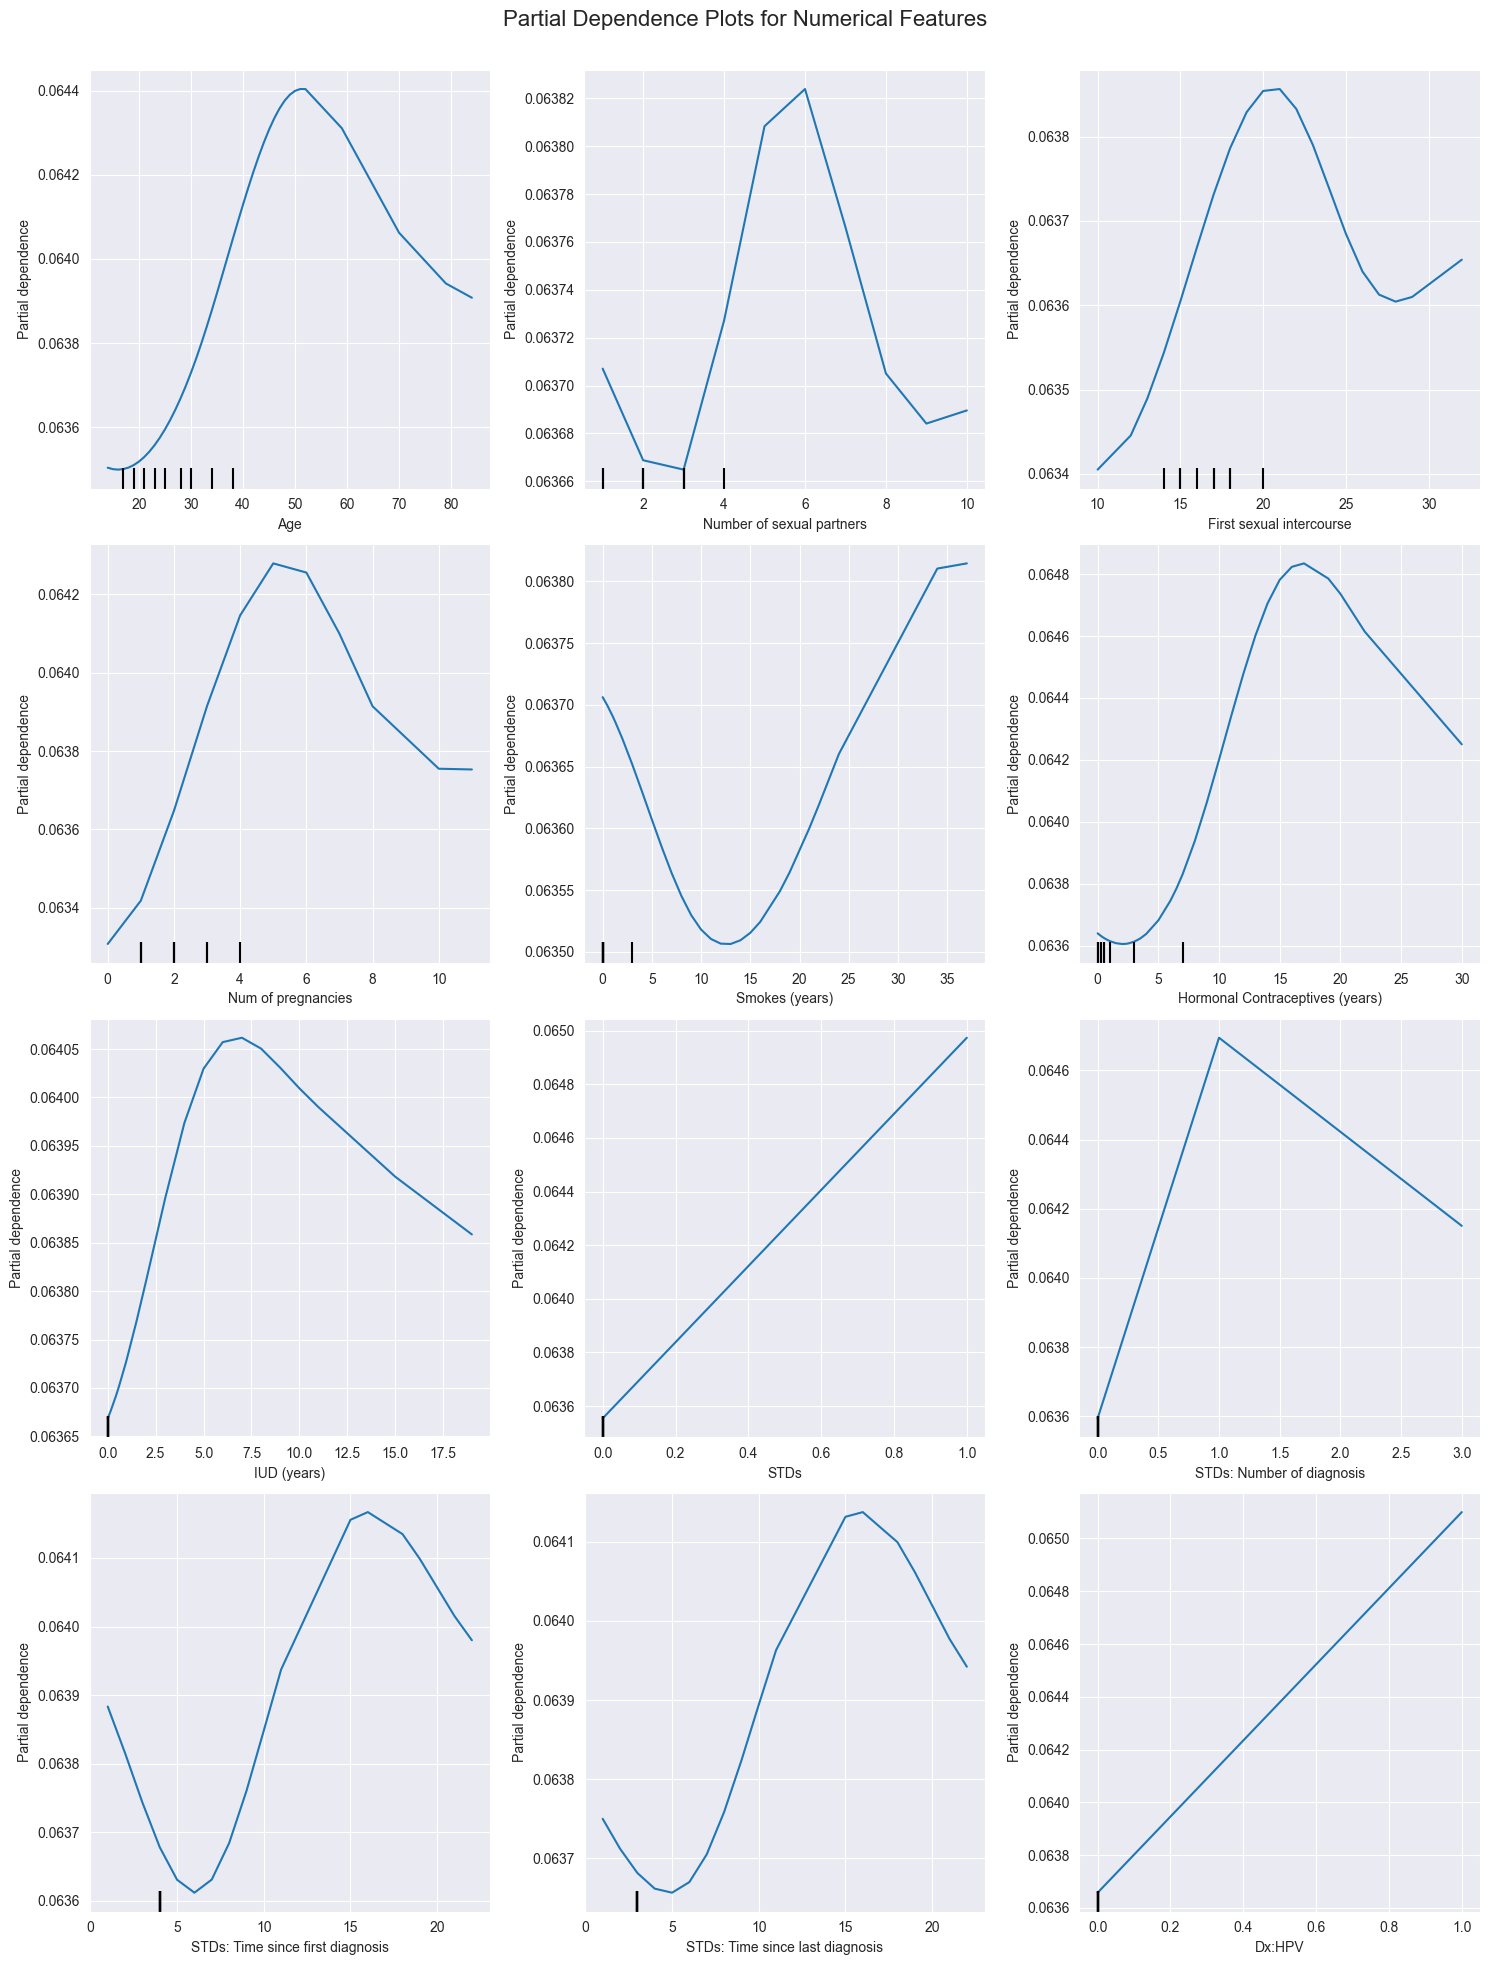

In [40]:
from sklearn.inspection import PartialDependenceDisplay
import math


def plot_partial_dependence(model, X=X_train, cols=3):
    numerical_features = X.select_dtypes(include='number').columns

    number_of_rows = math.ceil(len(numerical_features) / cols)
    fig, ax = plt.subplots(number_of_rows, cols, figsize=(15, 5 * number_of_rows))

    ax = ax.flatten()
    for i, feature in enumerate(numerical_features):
        PartialDependenceDisplay.from_estimator(
            model, X, [feature], ax=ax[i]
        )
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.suptitle('Partial Dependence Plots for Numerical Features', fontsize=16)
    plt.show()


plot_partial_dependence(gam_model)

### 4.	Calculate the feature effects (you can adapt the code snippet from the tutorial).

In [75]:
gam_features_effects = calculate_feature_effects(gam_model)

In [72]:
def plot_feature_effects(feature_effects):
    fig, ax = plt.subplots(figsize=(12, 5))
    sns.boxplot(data=feature_effects, showmeans=True)
    plt.xticks(rotation=30)
    plt.xlabel('Effect')
    plt.grid()

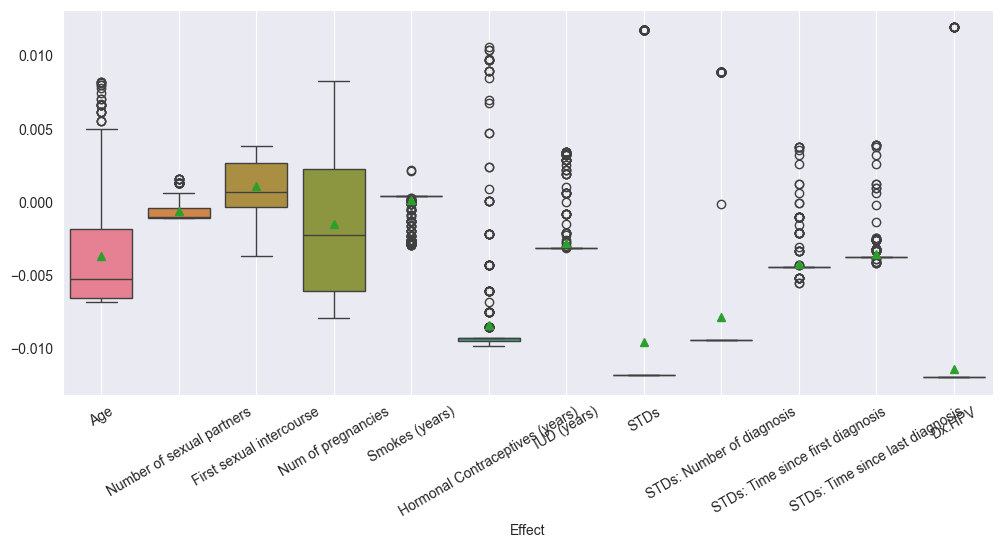

In [73]:
plot_feature_effects(gam_features_effects)

### 5.	What are the most and least important features? Comment on the differences.

Most important: STDs (0.0069)
Least important: Number of sexual partners (0.0006)


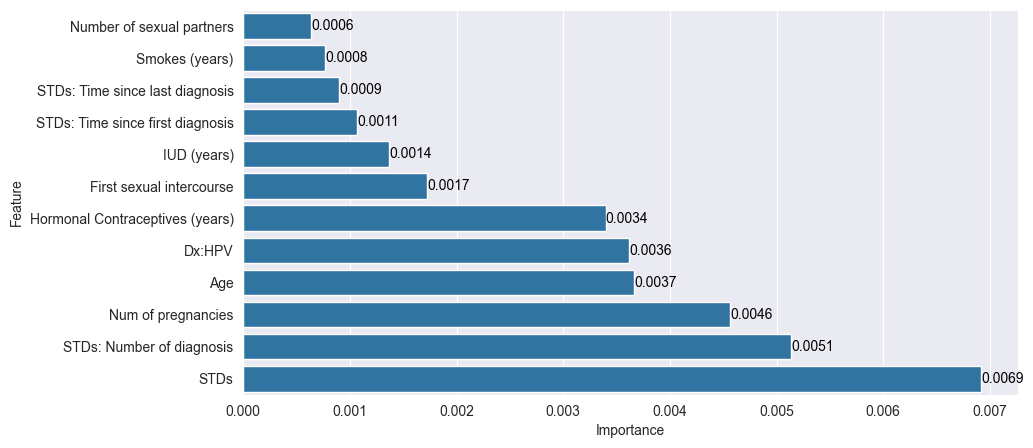

In [86]:
plot_feature_importance(gam_features_effects)

Whereas in the logistic regression model, `Age` and `Hormonal Contraceptives (in years)` were significantly the most important features, capturing most of the feature importance, resulted in a pretty skewed bar plot. The GAM model shows a more balanced distribution of feature importance. 
 
In the GAM model, importance of features like `STDs` and `Dx:HPV` increased significantly, showing that the GAM model was able to capture the non-linear relationships between the features and the target variable.  

---

## D. Black-box Classifier Model
A model taking into account interactions between features could yield better predictive performance at the cost of reduced interpretability. We will build such a black-box model and use a-posteriori interpretation/explanation methods.

### 1.	Train a Random Forest classifier (sklearn.ensemble.RandomForestClassifier) with n_estimators=200 trees. 
Optimize the min_samples_leaf hyperparameter (from 1 to 100) using cross-validation over the train set (use sklearn.model_selection.GridSearchCV and sklearn.model_selection.KFold).

In [90]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold

def train_random_forest(X_train, y_train):
    rf_model = RandomForestClassifier(n_estimators=200, random_state=42)

    param_grid = {'min_samples_leaf': range(1, 101)}
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=kf, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_rf_model = grid_search.best_estimator_
    print(f'Best min_samples_leaf: {grid_search.best_params_["min_samples_leaf"]}')

    return best_rf_model

# Train the Random Forest model
rf_model = train_random_forest(X_train, y_train)

Best min_samples_leaf: 5


### 2.	Determine the feature importance using the permutation importance metric on the train and test set and visualize them (sklearn.inspection.permutation_importance).

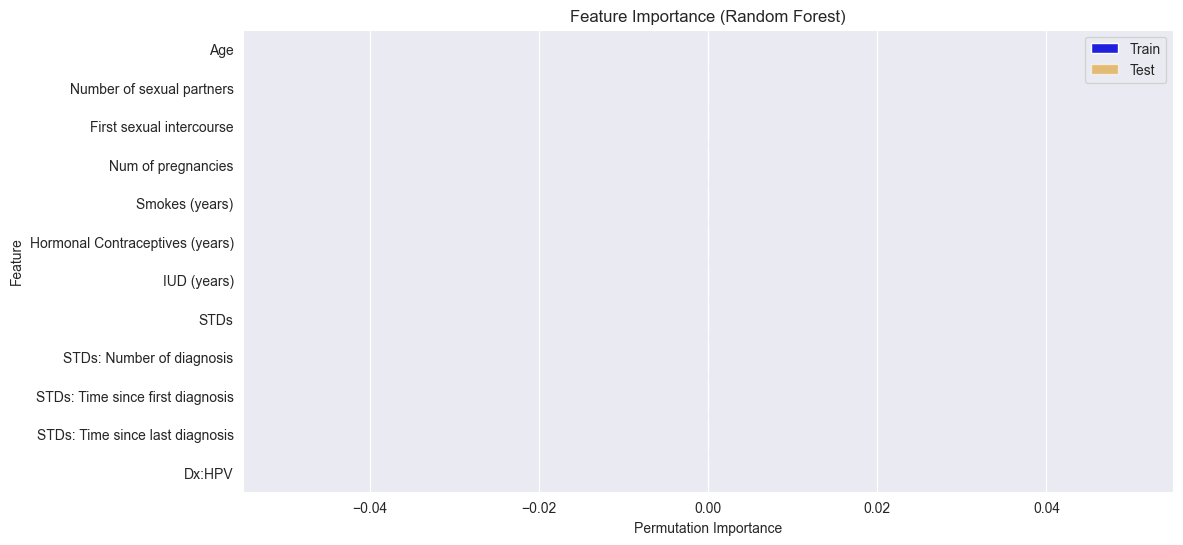

In [91]:
from sklearn.inspection import permutation_importance

def plot_permutation_importance(model, X_train, y_train, X_test, y_test):
    train_importance = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)
    test_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

    train_importances_mean = train_importance.importances_mean
    test_importances_mean = test_importance.importances_mean

    feature_names = X_train.columns

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Train Importance': train_importances_mean,
        'Test Importance': test_importances_mean
    }).sort_values(by='Train Importance', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Train Importance', y='Feature', data=importance_df, label='Train', color='blue')
    sns.barplot(x='Test Importance', y='Feature', data=importance_df, label='Test', color='orange', alpha=0.6)
    plt.xlabel('Permutation Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance (Random Forest)')
    plt.legend()
    plt.show()

    return importance_df

# Plot permutation importance for the Random Forest model
importance_df = plot_permutation_importance(rf_model, X_train, y_train, X_test, y_test)


In [88]:
best_rf_model

RandomForestClassifier(min_samples_leaf=5, n_estimators=200, random_state=42)

### 3.	Conclude on the most important features, and on the features for which overfitting occurs. Are the conclusions different from previously? Why?

### 4.	Using the alibi package (Accumulated Local Effects (ALE)), plot the Accumulated Local Effects for all numerical features and report them. How do the ALE plots compare with the partial dependence plots of the GAM model?

---

## E. Shapley Values

Let us now try to compare how each model relies on each feature, and explain individual predictions. Using the TreeExplainer class of the shap package, calculate the Shapley values of the Random Forest model over the test set.

### 1.	Visualize the Shapley values using a summary plot. How do they compare to ALE plots?

### 2.	Calculate the Shapley feature importance, as the average of the absolute value of the Shapley values. How do they compare to the feature importances determined in D.2?

### 3.	Pick two test set instances for which the Random Forest model makes an incorrect prediction. Explain their corresponding prediction using a Shapley values force plot.

## F. Bonus

Based on the various model interpretations provided, can you come up with a better model, based on a different set of features?